C:\Users\yocan\AppData\Local\Temp\ipykernel_6716\447355770.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  wind_df_hourly = wind_df.set_index("Date/heure")[numeric_cols].resample("H").mean().reset_index()


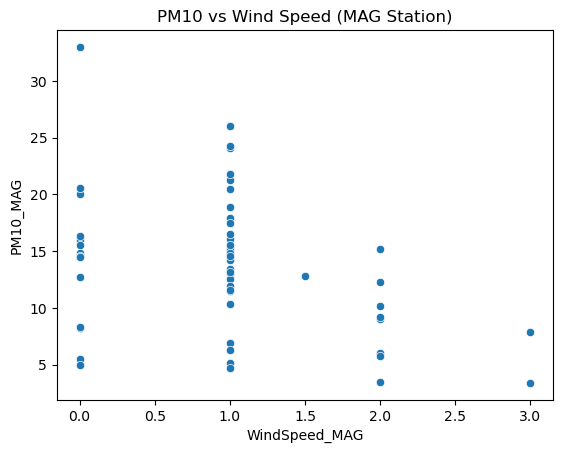

Pearson correlation between PM10 and Wind Speed (MAG): -0.34


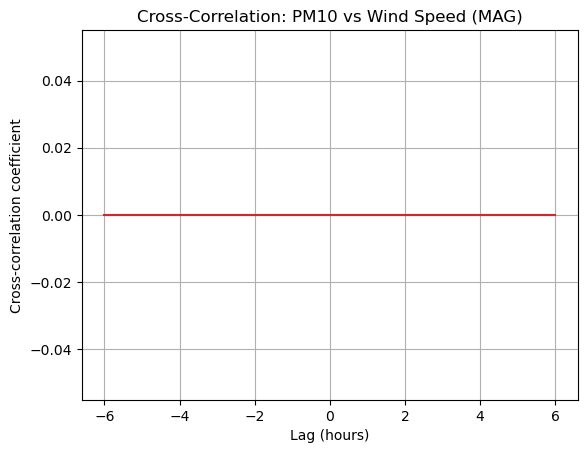

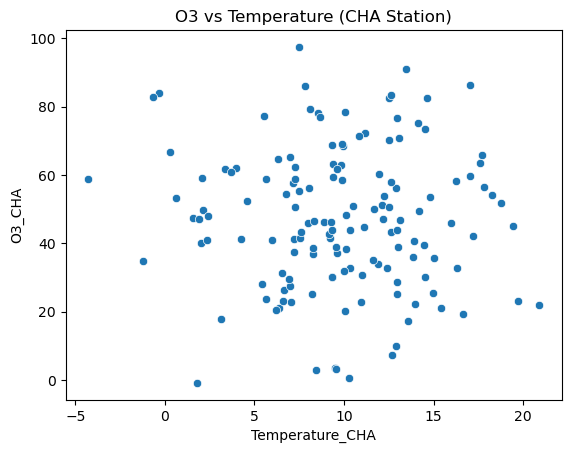

Pearson correlation between Temperature and O3 (CHA): -0.04


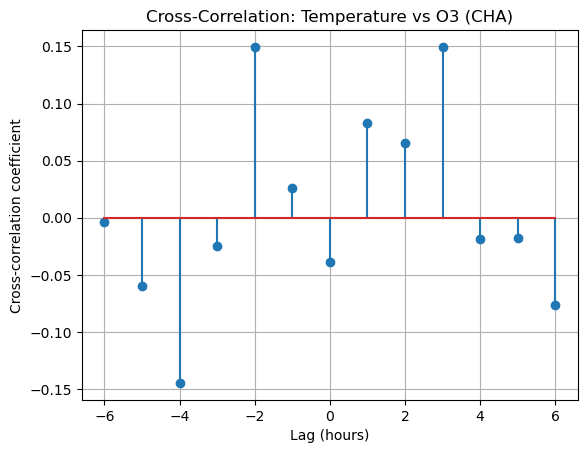

Lagged correlation results saved to 'lagged_correlations.csv'


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import ccf

# Load pollutant and meteorological data for two stations
# Replace with your actual file paths
pm10_df = pd.read_csv("PM10.csv", sep=",", parse_dates=["Date/heure"])
wind_df = pd.read_csv("wind Speed and Direction.csv", sep=";", parse_dates=["time"])

# Ensure the 'vMAG' column is numeric
wind_df["vMAG"] = pd.to_numeric(wind_df["vMAG"], errors='coerce')

# Convert 'time' column to datetime (if not already converted)
wind_df["time"] = pd.to_datetime(wind_df["time"], errors="coerce")

# Rename 'time' to match 'Date/heure' and resample wind data hourly
wind_df = wind_df.rename(columns={"time": "Date/heure"})

# Select numeric columns for resampling and resample wind data by hour
numeric_cols = wind_df.select_dtypes(include=[np.number]).columns
wind_df_hourly = wind_df.set_index("Date/heure")[numeric_cols].resample("H").mean().reset_index()

# Ensure 'Date/heure' column in pm10_df is datetime
pm10_df["Date/heure"] = pd.to_datetime(pm10_df["Date/heure"], errors="coerce")

# Merge the two datasets on 'Date/heure'
data = pd.merge(pm10_df, wind_df_hourly, on="Date/heure", how="inner")

# Focus on MAG station (assuming the column names exist in the merged data)
data["PM10_MAG"] = data["Magadino-Cadenazzo"]
data["WindSpeed_MAG"] = data["vMAG"]

# Scatter plot of PM10 vs Wind Speed
sns.scatterplot(x="WindSpeed_MAG", y="PM10_MAG", data=data)
plt.title("PM10 vs Wind Speed (MAG Station)")
plt.show()

# Calculate Pearson correlation
correlation = data[["PM10_MAG", "WindSpeed_MAG"]].corr().iloc[0,1]
print(f"Pearson correlation between PM10 and Wind Speed (MAG): {correlation:.2f}")

# Cross-correlation function (lagged correlation)
def compute_cross_correlation(x, y, max_lag):
    result = []
    for lag in range(-max_lag, max_lag+1):
        if lag < 0:
            corr = np.corrcoef(x[:lag], y[-lag:])[0,1]
        elif lag > 0:
            corr = np.corrcoef(x[lag:], y[:-lag])[0,1]
        else:
            corr = np.corrcoef(x, y)[0,1]
        result.append(corr)
    return np.array(result)

max_lag = 6  # hours
lags = np.arange(-max_lag, max_lag+1)
cross_corr = compute_cross_correlation(data["PM10_MAG"].values, data["WindSpeed_MAG"].values, max_lag)

# Plot lagged correlations
plt.stem(lags, cross_corr)
plt.xlabel("Lag (hours)")
plt.ylabel("Cross-correlation coefficient")
plt.title("Cross-Correlation: PM10 vs Wind Speed (MAG)")
plt.grid(True)
plt.show()

# -------------------------------
# Example 2: Temperature vs O3 (Chaumont)
# -------------------------------

# Simulating Temperature and O3 (replace with actual data columns)
data["Temperature_CHA"] = np.random.normal(10, 5, len(data))  # replace with real TEMP data
data["O3_CHA"] = np.random.normal(50, 20, len(data))          # replace with real O3 data

# Scatter plot
sns.scatterplot(x="Temperature_CHA", y="O3_CHA", data=data)
plt.title("O3 vs Temperature (CHA Station)")
plt.show()

# Correlation
correlation2 = data[["Temperature_CHA", "O3_CHA"]].corr().iloc[0,1]
print(f"Pearson correlation between Temperature and O3 (CHA): {correlation2:.2f}")

# Cross-correlation function (lagged)
cross_corr2 = compute_cross_correlation(data["Temperature_CHA"].values, data["O3_CHA"].values, max_lag)

# Plot lagged correlations for Temperature vs O3
plt.stem(lags, cross_corr2)
plt.xlabel("Lag (hours)")
plt.ylabel("Cross-correlation coefficient")
plt.title("Cross-Correlation: Temperature vs O3 (CHA)")
plt.grid(True)
plt.show()

# Save correlation results
results = pd.DataFrame({
    "Lag (hours)": lags,
    "PM10 vs WindSpeed (MAG)": cross_corr,
    "Temperature vs O3 (CHA)": cross_corr2
})
results.to_csv("lagged_correlations.csv", sep=";", index=False)
print("Lagged correlation results saved to 'lagged_correlations.csv'")